# Climate Change Sentiment Analysis

Challenge: 
Predict climate change sentiments of a user based on their twitter posts

---

## Honour Code

I {**MMAPITSO MASHILO**}, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the EA honour code.

## Overview

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

With this context, EA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.

Citation

ExploreAI Academy. (2023). EA - Twitter Sentiment Classification 2023-2024. Kaggle. https://kaggle.com/competitions/ea-twitter-sentiment-classification-2023-2024




## Outline

* Importing relevant packages
* Loading the data
* Initial Exploratory Data Analysis
* Data Engineering
* Exploratory Data Analysis
* Building and Testing Classifiers 
* Testing the Classifies 
* Selecting the Best Model


### 1. Importing relevant packages

In [1]:
# Importing starter data analysis packages

import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
%matplotlib inline

# Importing Natural Language Processing and data processing packages
import re
import nltk
from sklearn.utils import resample
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Importing model and model selection packages
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score, make_scorer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Importing metric packages
from sklearn import metrics

# Random state variable
RS = 1

### 2. Loading the data

In [2]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test_with_no_labels.csv')
df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [3]:
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


### 3. Initial Exploratory Data Analysis

In [4]:
# Checking column data types and null values 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10546 entries, 0 to 10545
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  10546 non-null  object
 1   tweetid  10546 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 164.9+ KB


In [6]:
# Count values for the sentiments to check for class balance
df['sentiment'].value_counts()

sentiment
 1    8530
 2    3640
 0    2353
-1    1296
Name: count, dtype: int64

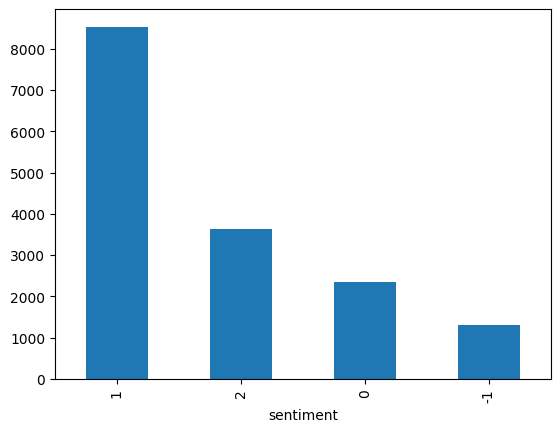

In [7]:
# Plotting value counts
df['sentiment'].value_counts().plot(kind='bar')
plt.show()

### 4. Data Engineering

In [8]:
# Replace links with urlweb text
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
df['message'] = df['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)
test['message'] = test['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)

In [9]:
# Transform text to lowercase
df['message'] = df['message'].str.lower()
test['message'] = test['message'].str.lower()

In [10]:
# Remove the twitter handles starting with an @ 
handles = r'@[^ ]+'
df['message'] = df['message'].replace(to_replace = handles, value = '', regex = True)
test['message'] = test['message'].replace(to_replace = handles, value = '', regex = True)

In [11]:
def remove_numbers(numbers):
    return ''.join([m for m in numbers if m not in string.digits])

In [12]:
df['message'] = df['message'].apply(remove_numbers)
test['message'] = test['message'].apply(remove_numbers)

In [13]:
# Remove punctuation
def remove_punctuation(message):
    return ''.join([m for m in message if m not in string.punctuation])

In [14]:
df['message'] = df['message'].apply(remove_punctuation)
test['message'] = test['message'].apply(remove_punctuation)

In [15]:
# Tokenize words
tokenizer = nltk.TreebankWordTokenizer()
df['tokens'] = df['message'].apply(tokenizer.tokenize)
test['tokens'] = test['message'].apply(tokenizer.tokenize)

In [16]:
# Remove the letters 'rt' which mean retweet
def remove_rt(tokens):
    return [t for t in tokens if t != 'rt']

In [17]:
df['tokens'] = df['tokens'].apply(remove_rt)
test['tokens'] = test['tokens'].apply(remove_rt)

In [18]:
# Remove stop words
def remove_stop_words(tokens):
    stop_words = list(nltk.corpus.stopwords.words('english'))
    return [t for t in tokens if t not in stop_words]

In [19]:
df['tokens'] = df['tokens'].apply(remove_stop_words)
test['tokens'] = test['tokens'].apply(remove_stop_words)

In [20]:
# test
df.head()

,sentiment,message,tweetid,tokens
0,1,polyscimajor epa chief doesnt think carbon dio...,625221,"[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,its not like we lack evidence of anthropogenic...,126103,"[like, lack, evidence, anthropogenic, global, ..."
2,2,rt researchers say we have three years to act...,698562,"[researchers, say, three, years, act, climate,..."
3,1,todayinmaker wired was a pivotal year in the...,573736,"[todayinmaker, wired, pivotal, year, war, clim..."
4,1,rt its and a racist sexist climate change de...,466954,"[racist, sexist, climate, change, denying, big..."


In [21]:
test.head()

,message,tweetid,tokens
0,europe will now be looking to china to make su...,169760,"[europe, looking, china, make, sure, alone, fi..."
1,combine this with the polling of staffers re c...,35326,"[combine, polling, staffers, climate, change, ..."
2,the scary unimpeachable evidence that climate ...,224985,"[scary, unimpeachable, evidence, climate, chan..."
3,\nputin got to you too jill \ntrump doesn...,476263,"[putin, got, jill, trump, doesnt, believe, cli..."
4,rt female orgasms cause global warming\nsarca...,872928,"[female, orgasms, cause, global, warming, sarc..."


In [22]:
wl = nltk.WordNetLemmatizer()
lemmas = []
for tokens in df['tokens']:
    lemmas.append([wl.lemmatize(token) for token in tokens])


In [23]:
df['lemmas'] = lemmas

In [24]:
test_lemmas = []
for tokens in test['tokens']:
    test_lemmas.append([wl.lemmatize(token) for token in tokens])

In [25]:
test['lemmas'] = test_lemmas

In [26]:
# Join tokens into message
def join(tokens):
    return ' '.join([l for l in tokens])

In [27]:
df['message_clean'] = df['lemmas'].apply(join)
test['message_clean'] = test['lemmas'].apply(join)

In [28]:
symbols = r'[^a-z0-9\s]'


In [29]:
df['message_clean'] = df['message_clean'].replace(to_replace = symbols, value = '', regex = True)
test['message_clean'] = test['message_clean'].replace(to_replace = symbols, value = '', regex = True)

In [30]:
df = df.drop(['message', 'tokens', 'lemmas'], axis=1)
test = test.drop(['message', 'tokens', 'lemmas'], axis=1)

In [31]:
df.head()

,sentiment,tweetid,message_clean
0,1,625221,polyscimajor epa chief doesnt think carbon dio...
1,1,126103,like lack evidence anthropogenic global warming
2,2,698562,researcher say three year act climate change i...
3,1,573736,todayinmaker wired pivotal year war climate ch...
4,1,466954,racist sexist climate change denying bigot lea...


In [32]:
test.head()

,tweetid,message_clean
0,169760,europe looking china make sure alone fighting ...
1,35326,combine polling staffer climate change woman r...
2,224985,scary unimpeachable evidence climate change al...
3,476263,putin got jill trump doesnt believe climate ch...
4,872928,female orgasm cause global warming sarcastic r...


Solving Class Imbalance in our Dataset

In [33]:
# Separating the classes
news = df[df['sentiment']==2]
pro = df[df['sentiment']==1]
neutral = df[df['sentiment']==0]
anti = df[df['sentiment']==-1]


In [34]:
# Setting the desired class size as half of the majority class
class_size = 4000

In [35]:
# Creating a function to upsample our minority classes
minority = [news, neutral, anti]
resampled = []
for m in minority:
    resampled.append(resample(m, replace=True, n_samples=class_size, random_state=1))



In [36]:
# Downsampling the majority class
resampled.append(resample(pro, replace=False, n_samples=class_size, random_state=1))

In [37]:
resampled_data = np.concatenate(resampled, axis=0)

In [38]:
df_resampled = pd.DataFrame(resampled_data, columns=['sentiment', 'tweetid', 'message'])

In [39]:
df_resampled

,sentiment,tweetid,message
0,2,587303,earthchanges brisbane time nowhere earth safe ...
1,2,958767,defy stalinist global warming rule burn much c...
2,2,489291,australia pm adviser say climate change unled ...
3,2,174142,role terrestrial biosphere counteracting clima...
4,2,20258,obama put pressure trump adhere u climate chan...
...,...,...,...
15995,1,220053,resist isnt im going dead jerry brown necessar...
15996,1,885844,already feeling impact climate change exiting ...
15997,1,269838,think trump need turn ac trump tower understan...
15998,1,527029,president doesnt believe global warming vp doe...


In [40]:
df_resampled.to_csv('resampled.csv')

In [41]:
# Create tf-idf vector for train test dataset
tfidf = TfidfVectorizer(min_df=0.00)
tf_vect = tfidf.fit_transform(df_resampled['message'])

In [42]:
tf_tokens = tfidf.get_feature_names_out()

In [43]:
result = pd.DataFrame(
    data=tf_vect.toarray(), 
    columns=tf_tokens
)

result

,aaaaaaaaaaa,aaaaaand,aaaand,aag,aan,ab,abandon,abandoned,abandoning,abbot,...,zinke,zoals,zoe,zombie,zombification,zonde,zone,zoo,zum,zwizku
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Create tfidf vector for test only dataset
tf = TfidfVectorizer(min_df=0.001)
test_vect = tf.fit_transform(test['message_clean'])

In [45]:
test_tokens = tf.get_feature_names_out()

In [46]:
test_df = pd.DataFrame(
    data=test_vect.toarray(), 
    columns=test_tokens
)

test_df

,able,abortion,absolutely,accept,accord,according,account,acknowledge,act,acting,...,yes,yesterday,yet,yo,york,you,young,youre,youth,yr
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
10542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
10543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
10544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.479782,0.0,0.0


In [47]:
train_cols = list(result.columns)
test_cols = list(test_df.columns)

In [48]:
common_cols = [w for w in train_cols if w in test_cols]

In [49]:
len(common_cols)

1352

In [50]:
result = result[common_cols]
test_df = test_df[common_cols]

In [51]:
result['tweetid'] = df_resampled['tweetid']
result['sentiment'] = df_resampled['sentiment']
result.set_index('tweetid', inplace=True)

C:\Users\mmapi\AppData\Local\Temp\ipykernel_4600\4238039459.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['tweetid'] = df_resampled['tweetid']
C:\Users\mmapi\AppData\Local\Temp\ipykernel_4600\4238039459.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['sentiment'] = df_resampled['sentiment']


In [52]:
test_df['tweetid'] = test['tweetid']
test_df.set_index('tweetid', inplace=True)

In [53]:
y = result['sentiment']
#X = result.drop('sentiment', axis=1)
X = result.drop('sentiment', axis=1)
X = np.array(X)

In [54]:
enc = preprocessing.LabelEncoder()
y = enc.fit_transform(y)

In [55]:
result['sentiment'] = y

C:\Users\mmapi\AppData\Local\Temp\ipykernel_4600\2707066270.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['sentiment'] = y


In [56]:
test_df

,able,abortion,absolutely,accept,accord,according,account,acknowledge,act,acting,...,yes,yesterday,yet,yo,york,you,young,youre,youth,yr
tweetid,,,,,,,,,,,,,,,,,,,,,
169760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
35326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
224985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
476263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
872928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
875167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
78329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [57]:
# save test df to csv
test_df.to_csv('test_df.csv') 

### 5. Exploratory Data Analysis

news = 3
pro = 2
neutral = 1
anti = 0


In [58]:
result['sentiment'].unique()

array([3, 1, 0, 2])

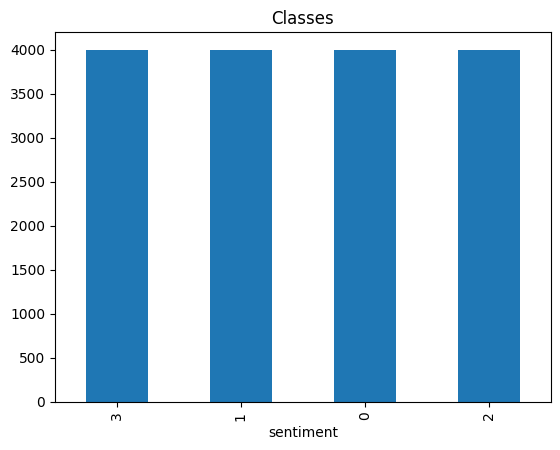

In [59]:
result['sentiment'].value_counts().plot(kind = 'bar')
plt.title('Classes')
plt.show()

### 6. Building the Classification Models

In [60]:
f1_scorer = make_scorer(f1_score, average='macro')

In [61]:
def scoring(y_test, y_pred):
    accuracy  = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    recall    = metrics.recall_score(y_test, y_pred, average='macro')
    f1        = metrics.f1_score(y_test, y_pred, average='macro')    
    return f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}'

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Logistic Regression

In [63]:
# Logistic Regression Model
lr = LogisticRegression(random_state=1, multi_class='ovr')

In [64]:
# Fitting the logist regression model
lr.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', random_state=1)

In [65]:
y_pred = lr.predict(X_test)

In [66]:
scoring(y_test, y_pred)

'Accuracy: 0.701875, Precision: 0.7019108882925129, Recall: 0.7029213984566, F1: 0.6997441345691964'

In [67]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.71      0.74       790
           1       0.64      0.67      0.65       769
           2       0.68      0.58      0.62       837
           3       0.73      0.85      0.78       804

    accuracy                           0.70      3200
   macro avg       0.70      0.70      0.70      3200
weighted avg       0.70      0.70      0.70      3200



In [68]:
lr_pred = lr.predict(np.array(test_df))

In [69]:
output_df = test_df

In [70]:
output_df['sentiment'] = lr_pred

In [71]:
output_df = output_df.drop(common_cols, axis=1)

In [72]:
output_df.to_csv('preds_lr_1.csv')

In [73]:
output_df

,sentiment
tweetid,
169760,3
35326,2
224985,2
476263,2
872928,1
...,...
895714,3
875167,3
78329,1


In [74]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

In [75]:
pred_mnb = mnb.predict(X_test)

In [76]:
scoring(y_test, pred_mnb)

'Accuracy: 0.655625, Precision: 0.6525663254666532, Recall: 0.6568039310519546, F1: 0.6512643964698662'

In [77]:
svc = SVC()

In [78]:
svc.fit(X_train, y_train)

SVC()

In [79]:
pred_svc = svc.predict(X_test)

In [80]:
scoring(y_test, pred_svc)

'Accuracy: 0.8321875, Precision: 0.8341661590442765, Recall: 0.8338543982498238, F1: 0.8324209524279829'

In [81]:
print(metrics.classification_report(y_test, pred_svc))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       790
           1       0.76      0.86      0.81       769
           2       0.81      0.72      0.76       837
           3       0.85      0.88      0.87       804

    accuracy                           0.83      3200
   macro avg       0.83      0.83      0.83      3200
weighted avg       0.83      0.83      0.83      3200



In [82]:
test_df

,able,abortion,absolutely,accept,accord,according,account,acknowledge,act,acting,...,yesterday,yet,yo,york,you,young,youre,youth,yr,sentiment
tweetid,,,,,,,,,,,,,,,,,,,,,
169760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,3
35326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2
224985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2
476263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2
872928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,3
875167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,3
78329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1


### 8. Selecting the Best Model

The Support Vector Machine tested the best out of all the models therefore it will be used to make the final predictions.

In [84]:
pred_svc_output = svc.predict(np.array(test_df.drop('sentiment', axis=1)))

In [85]:
cols_drop = test_df.columns

In [86]:
pred_svc_output = enc.inverse_transform(pred_svc_output)

In [87]:
output_df = test_df
output_df['sentiment'] = pred_svc_output

In [90]:
output_df = output_df.drop(common_cols, axis=1)

In [91]:
output_df

,sentiment
tweetid,
169760,1
35326,1
224985,1
476263,1
872928,0
...,...
895714,2
875167,1
78329,1


In [93]:
output_df.value_counts()

sentiment
 1           6239
 2           2551
 0           1058
-1            698
Name: count, dtype: int64

In [94]:
output_df.to_csv('predictions_svc_5.csv')